# Task 2: Building the baseline model

In [34]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [35]:
# List all physical GPUs available to TensorFlow
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPUs are available and recognized by TensorFlow:")
    for gpu in gpus:
        print(" -", gpu)
else:
    print("No GPU found. TensorFlow is running on the CPU.")


No GPU found. TensorFlow is running on the CPU.


In [36]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import seaborn as sns

import src.loading as loading
import src.models as models

importlib.reload(loading)
importlib.reload(models)


<module 'src.models' from 'c:\\Users\\seppe\\AI project\\AI-project\\notebooks\\src\\models.py'>

## 1. Set up the classification

In [37]:
# Choose a metric to evaluate the succes of the classifier.
metrics=['accuracy']

In [38]:
# Set a seed for NumPy and Keras for preproducibility.
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
# Set up image generators for the training, validation, and test data.
img_height, img_width = 128, 128
batch_size = 32
path = "../data"
train_data_gen, val_data_gen, train_and_val_data_gen, test_data_gen = loading.get_images(path, img_height, img_width, batch_size, norm="fixed")

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


## 2. Initial model

In [40]:
# Keras classifier model.
model = models.custom_CNN(
    (img_height, img_width, 1),
    dropout_rate = 0.1,
    filters = 16,
    dense_unit = 512,
    lr =0.001,
    metrics=metrics)

In [41]:
# Initial architecture.
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,929 (32.09 MB)

 Trainable params: 8,412,929 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Training the initial model

In [42]:
total_train = train_data_gen.samples
total_val = val_data_gen.samples

print(f"total_train: {total_train}")
print(f"total_val: {total_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train // batch_size}")

total_train: 1600
total_val: 400
batch_size: 32
steps_per_epoch: 50


In [ ]:
# Training the initial model.
epochs = 30

history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.6917 - loss: 0.5566 - val_accuracy: 0.8307 - val_loss: 0.3956
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.8651 - loss: 0.3196 - val_accuracy: 0.8333 - val_loss: 0.3722
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.8929 - loss: 0.2509 - val_accuracy: 0.8516 - val_loss: 0.3589
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9142 - loss: 0.2189 - val_accuracy: 0.8516 - val_loss: 0.3873
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9247 - loss: 0.1740 - val_accuracy: 0.8281 - val_loss: 0.4501


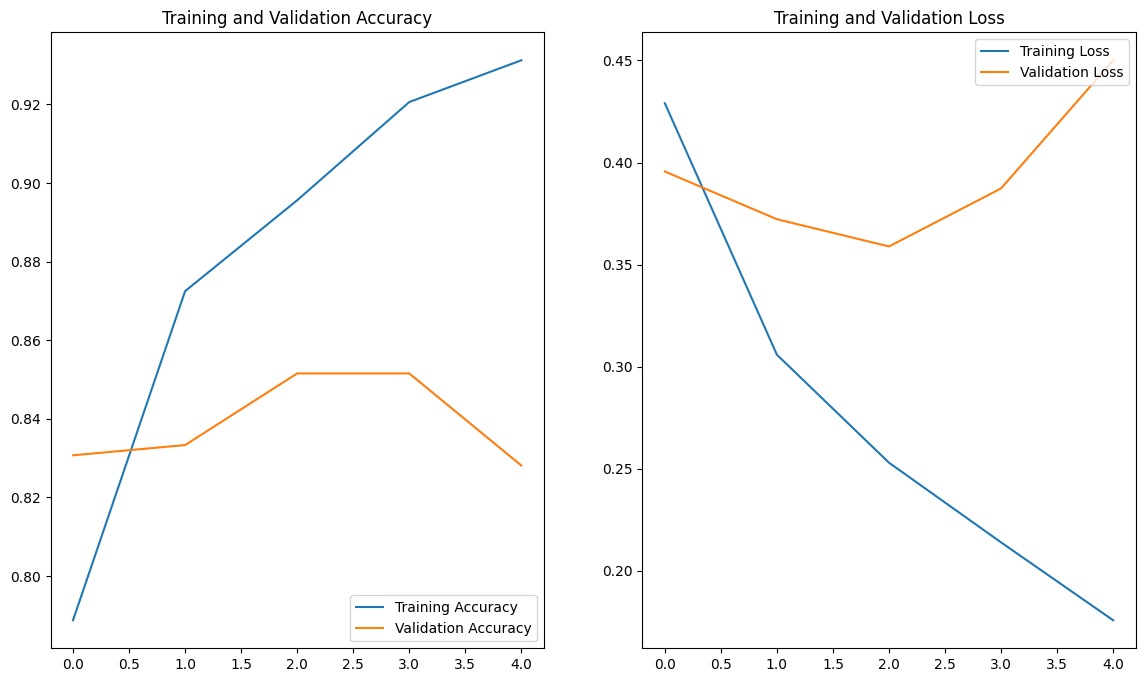

In [ ]:
# Plot the model history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4. Hyperparameter tuning

In [ ]:
# Implement the Keras EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
# Hyperparameter options.
dropout_rates = [0.1, 0.2]
first_filters = [16, 8]
learning_rates = [0.001, 0.0005]
dense_units = [512, 256]

# Create hyperparameter grid.
hyperparameter_grid = list(product(dropout_rates, first_filters, learning_rates, dense_units))

In [ ]:
# Rough parameter search.
epochs = 5

total_iterations = len(hyperparameter_grid)
results = []  # List to store results from each run.

print(f"Total iterations: {total_iterations}")

for idx, (dropout_rate, filters, lr, dense_unit) in enumerate(hyperparameter_grid):
    print(f"\nRunning: dropout={dropout_rate}, filters={filters}, lr={lr}, dense_units={dense_unit}")
    
    # Build the model with the current hyperparameters.
    model = models.custom_CNN(
        (img_height, img_width, 1),
        dropout_rate=dropout_rate,
        filters=filters,
        dense_unit=dense_unit,
        lr=lr,
        metrics=metrics
    )
    
    # Set up the optimizer and compile the model.
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    # Train the model.
    history = model.fit(
        train_data_gen,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks=[early_stop],
        verbose=0  # Reduce training output during tuning.
    )
    
    # Find the best validation accuracy and the corresponding epoch.
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    final_val_loss = history.history['val_loss'][best_epoch - 1]
    
    # Append hyperparameters and performance metrics to the results.
    results.append({
        'dropout_rate': dropout_rate,
        'first_filters': filters,
        'learning_rate': lr,
        'dense_units': dense_unit,
        'best_val_accuracy': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_loss': final_val_loss
    })
    print(f"Completed: best_val_accuracy={best_val_acc:.4f} at epoch {best_epoch}")

    print(idx + 1, "/", total_iterations, end="\r")  # Print progress.

# Move to a new line after the progress bar.
print("\nHyperparameter tuning complete.")

In [ ]:
# Create a DataFrame from the results and save to CSV.
df_results = pd.DataFrame(results)
csv_filename = "../results/hyperparameter_tuning_results.csv"
df_results.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

## 5. Final baseline model

In [43]:
# Select the best configuration based on highest validation accuracy.
results_csv = "../results/hyperparameter_tuning_results.csv"
df_results = pd.read_csv(results_csv)

best_config = df_results.sort_values('best_val_accuracy', ascending=False).iloc[0]
best_dropout = best_config['dropout_rate']
best_filters = int(best_config['first_filters'])
best_lr = best_config['learning_rate']
best_dense_units = int(best_config['dense_units'])

print("Best Hyperparameters:")
print(best_config)

Best Hyperparameters:
dropout_rate           0.100000
first_filters         16.000000
learning_rate          0.000500
dense_units          256.000000
best_val_accuracy      0.857500
best_epoch             5.000000
final_val_loss         0.333136
Name: 3, dtype: float64


In [44]:
# Final baseline model
best_model = models.custom_CNN(
    (img_height, img_width, 1),
    dropout_rate = best_dropout,
    filters = best_filters,
    dense_unit = best_dense_units,
    lr = best_lr,
    metrics=metrics)

best_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,113 (16.09 MB)

 Trainable params: 4,218,113 (16.09 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
total_train_and_val = train_and_val_data_gen.samples

print(f"total_train_and_val: {total_train_and_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train_and_val // batch_size}")

total_train_and_val: 2000
batch_size: 32
steps_per_epoch: 62


In [ ]:
# Retraining the model using the complete training dataset (including the validation dataset).
epochs_full = 10  # Adjust this as needed.

history_full = best_model.fit(
    train_and_val_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train_and_val // batch_size,
    epochs=epochs_full,
)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.6175 - loss: 0.7839
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.8125 - loss: 0.4136
Epoch 3/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.8125 - loss: 0.4493

c:\Users\seppe\AI project\AI-project\.env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8083 - loss: 0.4169
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - accuracy: 0.8750 - loss: 0.3004
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8557 - loss: 0.3327
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 1.0000 - loss: 0.1585
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.8942 - loss: 0.2685
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 131us/step - accuracy: 0.8125 - loss: 0.2712
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8838 - loss: 0.2681
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - accuracy: 0.6875 - loss: 0.5532


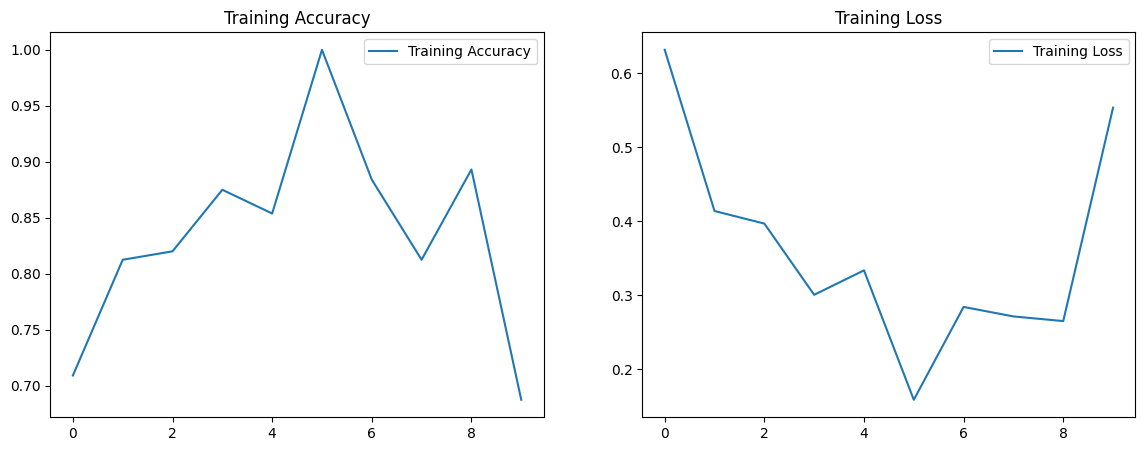

In [26]:
# Retrieve only the training history.
acc = history_full.history['accuracy']
loss = history_full.history['loss']
epochs_range = range(epochs_full)

# Plot only the training curves.
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [ ]:
# Save the retrained model to disk.
model_save_path = "../results/final_baseline.keras"

best_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to ../results/final_baseline.keras


In [45]:
# Reload the model from disk.
reloaded_model = load_model(model_save_path)
print("Model loaded from disk.")

Model loaded from disk.


In [46]:
total_test = test_data_gen.samples
steps_test = total_test // batch_size

print(f"total_test: {total_test}")
print(f"steps_test: {steps_test}")

total_test: 200
steps_test: 6


In [47]:
# Evaluate the reloaded model on the test set.
test_loss, test_accuracy = reloaded_model.evaluate(
    test_data_gen, 
    steps=steps_test,
    verbose=1,
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9097 - loss: 0.2647
Test Loss: 0.3266
Test Accuracy: 0.8594


In [48]:
# Generate predictions on the entire test set.
predictions = reloaded_model.predict(
    test_data_gen, 
    verbose=1
)

# For binary classification, use a threshold of 0.5.
predictions_class = (predictions > 0.5).astype(int).flatten()

# Get ground truth labels from the generator.
true_labels = test_data_gen.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


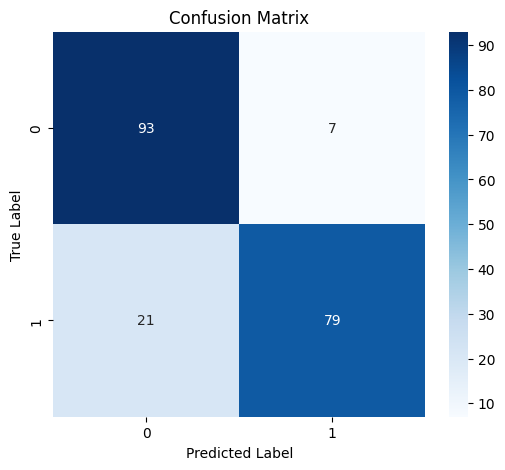

In [49]:
# Compute the confusion matrix.
cm = confusion_matrix(true_labels, predictions_class)

# Plot the confusion matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


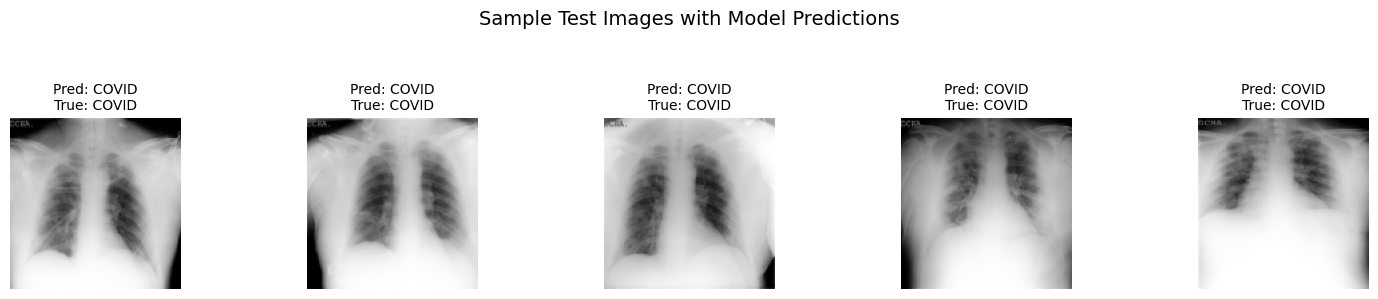

In [61]:
# Create a test data generator WITHOUT normalization (for displaying original images).
_, _, _, test_data_gen_no_norm = loading.get_images(
    path, 
    img_height, 
    img_width, 
    batch_size)

# Get one batch of images and their corresponding labels.
images, labels = next(iter(test_data_gen_no_norm))

# Plot a few sample images with the predicted labels.
num_images_to_plot = 5
plt.figure(figsize=(15, 3))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)
    # Display the original (non-normalized) image.
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    
    true_label_idx = int(labels[i].numpy().squeeze())
    true_label = test_data_gen.class_names[true_label_idx]
    pred_label = test_data_gen.class_names[predictions_class[i]]
    
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    plt.axis('off')
plt.suptitle("Sample Test Images with Model Predictions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.85])  # Leave space for suptitle
plt.show()

## Questions

**Question 7:** *Which metrics did you find appropriate for this task, and why?*

...

---

**Question 8:** *What conclusions can you draw from the training and validation curves on the history
plot of your initial model? Which hyperparameters would need to be optimized first?*

...

---

**Question 9:** *Did you observe signs of overfitting in your initial model? If so, which countermea-
sures against overfitting did you take?*

...

---

**Question 10:** *Which hyperparameter search strategy did you employ? Did you attempt all possible
combinations of parameter values (grid search) or optimize them one at a time? If you tuned the
hyperparameters sequentially, did you select the values to try upfront, or did you base them on the
performance of previous values?*

...

---

**Question 11:** *Which optimizer and which loss function did you select for this problem? Did you
try others? How did you compare them?*

...

---

**Question 12:** *What conclusions can you draw from the training curves on the history plot of your
final model?*

...